<a href="https://colab.research.google.com/github/rodrigo0345/Aprof2/blob/main/Task2_Transformer_e_Aten%C3%A7%C3%A3o_Temporal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install decord openpyxl pandas torch torchvision scikit-learn matplotlib seaborn numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.transforms import Normalize
import torch.optim as optim

import decord
from decord import VideoReader

# For Colab
from google.colab import drive

In [ ]:
# Seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
# Mount Google Drive (if using Colab)
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- Configuration & Paths ---
BASE_PATH = "drive/MyDrive/" # Adjust if your Drive structure is different
VIDEO_FILES_PATH = os.path.join(BASE_PATH, "suturas-filtered/")
LABELS_EXCEL_PATH = os.path.join(BASE_PATH, "OSATS.xlsx")

OSATS_COLUMNS_INDIVIDUAL = [
    'OSATS_RESPECT', 'OSATS_MOTION', 'OSATS_INSTRUMENT',
    'OSATS_SUTURE', 'OSATS_FLOW', 'OSATS_KNOWLEDGE',
    'OSATS_PERFORMANCE', 'OSATS_FINAL_QUALITY'
]

# --- Hyperparameters ---
batch_size = 4       # Adjust based on GPU memory (e.g., 2, 4, 8)
num_epochs = 1      # Number of training epochs
learning_rate = 1e-4 # Learning rate for Adam optimizer
embed_dim = 512      # Dimension for Transformer model's embeddings
num_heads = 8        # Number of attention heads in Transformer
num_layers = 4       # Number of Transformer encoder layers
num_frames_config = 64 # Number of frames to sample from each video
# `segments` can be None for linspace sampling, or an integer for segmented sampling.
# If using segmented sampling, num_frames_config should ideally match segments.
segments = None      # e.g., 8, 16, 32, or None for original linspace sampling.


In [ ]:
# --- Data Loading and Preprocessing ---
info_df_raw = pd.read_excel(LABELS_EXCEL_PATH)

# Filter DataFrame based on available video files
available_video_ids = [
    f.replace("output_prewitt_", "").replace(".mp4", "")
    for f in os.listdir(VIDEO_FILES_PATH)
    if os.path.isfile(os.path.join(VIDEO_FILES_PATH, f)) and f.startswith("output_prewitt_") and f.endswith('.mp4')
]
video_column_name = 'VIDEO' # Make sure this matches your Excel file column name

info_df = info_df_raw[info_df_raw[video_column_name].isin(available_video_ids)].copy() # Use .copy() to avoid SettingWithCopyWarning
print(f"Number of videos after filtering based on files in '{VIDEO_FILES_PATH}': {len(info_df)}")
# info_df.head() # Display first few rows

def update_info_df_with_score_vector(df: pd.DataFrame):
    """
    Ensures OSATS scores are numeric and creates a 'OSATS_SCORE_VECTOR' list.
    Drops rows where any OSATS score is NaN or cannot be converted to float.
    """
    processed_df = df.copy()
    osats_score_vectors = []
    rows_to_drop = []

    for index, row in processed_df.iterrows():
        current_vector = []
        valid_vector = True
        for col_name in OSATS_COLUMNS_INDIVIDUAL:
            score = row.get(col_name) # Use .get() for safer access
            if pd.isna(score):
                # print(f"NaN score for video {row[video_column_name]}, column {col_name}. Will drop row.")
                valid_vector = False
                break
            try:
                current_vector.append(float(score))
            except (ValueError, TypeError):
                # print(f"Conversion error for video {row[video_column_name]}, column {col_name}, value: {score}. Will drop row.")
                valid_vector = False
                break

        if valid_vector and len(current_vector) == len(OSATS_COLUMNS_INDIVIDUAL):
            osats_score_vectors.append(current_vector)
        else:
            osats_score_vectors.append(None) # Placeholder for rows to be dropped
            rows_to_drop.append(index)

    processed_df['OSATS_SCORE_VECTOR'] = osats_score_vectors

    original_len = len(processed_df)
    processed_df.drop(index=rows_to_drop, inplace=True)

    if rows_to_drop:
        print(f"Dropped {len(rows_to_drop)} rows due to missing or invalid OSATS scores.")
    print(f"Number of videos after ensuring valid OSATS_SCORE_VECTOR: {len(processed_df)}")
    return processed_df

info_df = update_info_df_with_score_vector(info_df)
# info_df[['VIDEO'] + OSATS_COLUMNS_INDIVIDUAL + ['OSATS_SCORE_VECTOR']].head()

Number of videos after filtering based on files in 'drive/MyDrive/suturas-filtered/': 90
Number of videos after ensuring valid OSATS_SCORE_VECTOR: 90


In [ ]:
# --- Device Configuration and DataLoader Helper ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

Using device: cpu


In [ ]:
# --- Video Dataset Class ---
class VideoDataset(Dataset):
    def __init__(self, df_dataset, cfg, dataset_path, segments_arg, segment_frame_pos=0) -> None:
        super().__init__()
        self.df_dataset = df_dataset
        self.dataset_path = dataset_path
        self.cfg = cfg
        self.label_columns = OSATS_COLUMNS_INDIVIDUAL
        self._segments = segments_arg
        self._segment_frame_pos = segment_frame_pos # Position within segment (0=start, 1=second, etc.)

    def __len__(self):
        return len(self.df_dataset)

    def __getitem__(self, idx):
        video_row = self.df_dataset.iloc[idx]
        video_id = video_row[video_column_name] # Use defined video column name
        video_file_name = "output_prewitt_" + str(video_id) + ".mp4"
        video_path = os.path.join(self.dataset_path, video_file_name)

        try:
            # Use decord.cpu(0) to avoid potential CUDA context issues with multiprocessing
            vr = decord.VideoReader(video_path, ctx=decord.cpu(0))
        except RuntimeError as e:
            print(f"Error loading video {video_path}: {e}. Skipping...")
            # This should ideally be handled by returning a dummy or by pre-filtering
            # For now, let's create a dummy tensor if a video fails to load
            # This part needs to be robust for real-world scenarios.
            dummy_frames = torch.zeros((3, self.cfg["num_frames"], 256, 256), dtype=torch.float)
            dummy_label = torch.zeros(len(self.label_columns), dtype=torch.float)
            return dummy_frames, dummy_label


        total_frames = len(vr)
        num_frames_to_sample = self.cfg["num_frames"]

        indices = []
        if total_frames == 0: # Handle empty video
            # print(f"Warning: Video {video_id} is empty. Using placeholder indices.")
            indices = [0] * num_frames_to_sample # Will try to get frame 0, then handle below
        elif self._segments is not None and self._segments > 0:
            # Segmented sampling: pick one frame from each of `_segments` segments
            num_frames_to_sample = self._segments # Override num_frames_config if segments is set

            # Create boundaries for segments
            # np.linspace(0, total_frames, self._segments + 1) gives N+1 points for N segments
            segment_boundaries = np.linspace(0, total_frames, self._segments + 1, dtype=int)

            for i in range(self._segments):
                start_idx = segment_boundaries[i]
                end_idx = segment_boundaries[i+1]

                # If segment is empty or points to same frame, use start_idx (or end_idx-1)
                if start_idx >= end_idx:
                    actual_idx_in_segment = min(start_idx, total_frames - 1)
                else:
                    # _segment_frame_pos is offset from start of segment
                    # e.g., 0 for first frame, 1 for second, etc.
                    # Ensure it's within the segment [start_idx, end_idx - 1]
                    target_pos = start_idx + self._segment_frame_pos
                    actual_idx_in_segment = min(target_pos, end_idx - 1)
                    actual_idx_in_segment = max(start_idx, actual_idx_in_segment) # Ensure it's not before start

                indices.append(int(actual_idx_in_segment))
            if len(indices) != num_frames_to_sample : # Should not happen if logic is correct
                print(f"Warning: Segment sampling for {video_id} resulted in {len(indices)} frames, expected {num_frames_to_sample}. Padding/truncating.")
                indices = (indices + [indices[-1] if indices else 0] * num_frames_to_sample)[:num_frames_to_sample]


        else: # Original linspace sampling (if _segments is None or 0)
            if total_frames >= num_frames_to_sample:
                indices = np.linspace(0, total_frames - 1, num_frames_to_sample, dtype=int).tolist()
            else: # Pad if fewer frames than num_frames_to_sample
                indices = list(range(total_frames)) + [total_frames - 1] * (num_frames_to_sample - total_frames)

        # Ensure all indices are valid if total_frames > 0
        if total_frames > 0:
            indices = [min(max(0, idx), total_frames - 1) for idx in indices]

        if total_frames == 0 or not indices: # If video is empty or indices list became empty
            frames_tensor = torch.zeros((3, num_frames_to_sample, 256, 256), dtype=torch.float)
            # print(f"Video {video_id} is empty or indices problem, returning zero tensor for frames.")
        else:
            try:
                frames_np = vr.get_batch(indices).asnumpy()  # [T, H, W, C], uint8
            except Exception as e: # Catch potential errors from get_batch with odd indices
                print(f"Error vr.get_batch for {video_id} with indices {indices}, total_frames {total_frames}: {e}")
                frames_tensor = torch.zeros((3, num_frames_to_sample, 256, 256), dtype=torch.float) # fallback
            else:
                frames_tensor = torch.from_numpy(frames_np).float() / 255.0 # [T, H, W, C]
                frames_tensor = frames_tensor.permute(0, 3, 1, 2)      # [T, C, H, W]

                # Normalize with ImageNet mean and std (standard for ResNet)
                mean = [0.485, 0.456, 0.406]
                std = [0.229, 0.224, 0.225]
                normalize_transform = Normalize(mean, std)
                # Apply normalization per frame (iterate over T dimension)
                # frames_tensor = torch.stack([normalize_transform(f) for f in frames_tensor]) # if T,C,H,W input
                frames_tensor = normalize_transform(frames_tensor) # Normalize expects (..., C, H, W), works for (T,C,H,W)

                # Resize and Crop (as per common practice for CNNs like ResNet)
                # Input to interpolate is (N, C, H_in, W_in) -> Output (N, C, H_out, W_out)
                # Here, N is T (num_frames_to_sample)
                _, _, H, W = frames_tensor.shape

                # Short side scale to 256 (common practice)
                if H == 0 or W == 0: # Safety check for empty frames from vr.get_batch
                    # print(f"Warning: Frame dimensions are zero for {video_id}. Returning zero tensor.")
                    frames_tensor = torch.zeros((3, num_frames_to_sample, 256, 256), dtype=torch.float)
                else:
                    if H < W:
                        new_H = 256
                        new_W = int(256 * W / H)
                    else:
                        new_W = 256
                        new_H = int(256 * H / W)

                    frames_tensor = F.interpolate(frames_tensor, size=(new_H, new_W), mode='bilinear', align_corners=False)

                    # Center crop to 224x224 (standard for ResNet) or 256x256
                    crop_size = 256 # Or 224 if preferred for ResNet
                    start_h = max(0, (new_H - crop_size) // 2)
                    start_w = max(0, (new_W - crop_size) // 2)
                    frames_tensor = frames_tensor[:, :, start_h:start_h + crop_size, start_w:start_w + crop_size]

                    # Ensure the cropped size is correct, pad if necessary (e.g. if original was smaller than crop_size)
                    _, _, ch, cw = frames_tensor.shape
                    if ch < crop_size or cw < crop_size:
                        padding_h = crop_size - ch
                        padding_w = crop_size - cw
                        # (pad_left, pad_right, pad_top, pad_bottom)
                        frames_tensor = F.pad(frames_tensor, (padding_w // 2, padding_w - padding_w // 2,
                                                              padding_h // 2, padding_h - padding_h // 2))


                # Permute to [C, T, H, W] for the model (video_frames in model is [B, C, T, H, W])
                frames_tensor = frames_tensor.permute(1, 0, 2, 3) # C, T, H, W

        # Labels from OSATS_SCORE_VECTOR
        label_vector = video_row['OSATS_SCORE_VECTOR']
        # Ensure it's a list of floats before converting to tensor
        try:
            label = torch.tensor([float(score) for score in label_vector], dtype=torch.float)
        except TypeError: # If label_vector is None (e.g. row was problematic but not dropped)
            # print(f"Warning: OSATS_SCORE_VECTOR is None for video {video_id}. Using zero label.")
            label = torch.zeros(len(self.label_columns), dtype=torch.float)


        return frames_tensor, label

In [ ]:
# --- Prepare DataLoaders ---
def prepare_data_loaders(main_df, base_video_path, segments_cfg): # Definition uses segments_cfg
    if len(main_df) < 10: # Arbitrary small number, adjust as needed
        print("Warning: Dataset is very small. Splitting might result in tiny validation/test sets.")
        # Handle very small datasets, e.g., use all for training or a different split strategy
        # For now, proceed with caution.
        if len(main_df) < 3: # Not enough for train/val/test
            print("Error: Dataset too small to split into train/val/test. Needs at least 3 samples.")
            return None, None, None


    train_df, temp_df = train_test_split(main_df, test_size=0.3, random_state=42, stratify=None) # Stratify might be useful if you had a key class

    # Ensure temp_df is not too small for another split
    if len(temp_df) < 2: # Need at least 2 samples to split into val and test
        print("Warning: Not enough samples for a separate validation and test set after initial split. Combining val and test or using K-fold might be better.")
        # Option: use temp_df as validation, and a subset of train_df or temp_df as test, or skip test
        if len(temp_df) == 1:
            val_df = temp_df
            test_df = temp_df # Use the same for test if only one sample left
        else: # temp_df is empty
            val_df = train_df.sample(1) if len(train_df) > 0 else pd.DataFrame(columns=main_df.columns) # take one from train if possible
            test_df = train_df.sample(1) if len(train_df) > 0 else pd.DataFrame(columns=main_df.columns)

    else:
        val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=None)


    cfg_dataset = {
        "num_frames": num_frames_config  # This will be overridden by segments_cfg if segments_cfg is an int > 0
    }

    train_dataset = VideoDataset(train_df, cfg_dataset, base_video_path, segments_cfg) # VideoDataset receives segments_cfg
    val_dataset = VideoDataset(val_df, cfg_dataset, base_video_path, segments_cfg)   # VideoDataset receives segments_cfg
    test_dataset = VideoDataset(test_df, cfg_dataset, base_video_path, segments_cfg)  # VideoDataset receives segments_cfg

    # Determine num_workers based on CPU cores, careful on shared systems
    num_workers = min(os.cpu_count() // 2 if os.cpu_count() else 0, 4) # Cap at 4 or a reasonable number

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, drop_last=True if len(train_dataset) > batch_size else False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    print(f"Train dataset size: {len(train_dataset)}, Val dataset size: {len(val_dataset)}, Test dataset size: {len(test_dataset)}")
    return train_loader, val_loader, test_loader

if not info_df.empty:
    # CORRECTED LINE HERE:
    train_dl_raw, val_dl_raw, test_dl_raw = prepare_data_loaders(info_df, VIDEO_FILES_PATH, segments_cfg=segments)

    if train_dl_raw: # Check if dataloaders were created
        # Wrap with DeviceDataLoader
        train_dl = DeviceDataLoader(train_dl_raw, device)
        val_dl = DeviceDataLoader(val_dl_raw, device)
        test_dl = DeviceDataLoader(test_dl_raw, device)

        print(f"Train Dataloader: {len(train_dl_raw)} batches")
        print(f"Validation Dataloader: {len(val_dl_raw)} batches")
        print(f"Test Dataloader: {len(test_dl_raw)} batches")
    else:
        print("Failed to create DataLoaders. Check dataset size and splitting logic.")
        # Set to None to prevent errors later if training is attempted
        train_dl, val_dl, test_dl = None, None, None
else:
    print("info_df is empty. Cannot prepare data loaders.")
    train_dl, val_dl, test_dl = None, None, None

Train dataset size: 63, Val dataset size: 13, Test dataset size: 14
Train Dataloader: 15 batches
Validation Dataloader: 4 batches
Test Dataloader: 4 batches


In [ ]:
# --- Model Definition (Positional Encoding & VideoTransformerModel) ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000): # max_len should be >= num_frames_config
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # Original PDF had .unsqueeze(0).transpose(0,1) for [max_len, 1, d_model] assuming batch_first=False.
        # For batch_first=False (seq_len, batch, feature), pe should be [seq_len, 1, d_model]
        pe = pe.unsqueeze(1) # [max_len, 1, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x expected in shape [seq_len, batch_size, d_model] for batch_first=False
        # self.pe is [max_len, 1, d_model]. We need [:x.size(0)] part of it.
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class VideoTransformerModel(nn.Module):
    def __init__(self, cnn_model_name='resnet50', embed_dim=512, num_heads=8, num_transformer_layers=4,
                 num_frames_for_pe=64, num_classes=8, cnn_pretrained=True):
        super(VideoTransformerModel, self).__init__()
        self.embed_dim = embed_dim

        # 1. CNN for frame embeddings
        if cnn_model_name == 'resnet50':
            weights = models.ResNet50_Weights.IMAGENET1K_V1 if cnn_pretrained else None
            self.cnn = models.resnet50(weights=weights)
            cnn_out_features = self.cnn.fc.in_features
            self.cnn.fc = nn.Identity() # Output features from penultimate layer
        else:
            raise ValueError(f"Unsupported CNN model: {cnn_model_name}")

        # 2. Projection layer (from CNN output to Transformer input dimension)
        self.frame_proj = nn.Linear(cnn_out_features, embed_dim)

        # 3. Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model=embed_dim, max_len=num_frames_for_pe)

        # 4. Transformer Encoder
        # batch_first=False means input tensor shape: (sequence_length, batch_size, embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads,
                                                   dim_feedforward=4 * embed_dim, dropout=0.1, batch_first=False)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)

        # 5. Output layer for regression (predicting num_classes scores)
        self.fc_out = nn.Linear(embed_dim, num_classes)

    def forward(self, video_frames):
        # video_frames: tensor of shape [B, C, T, H, W] (from DataLoader)
        B, C, T, H, W = video_frames.shape

        # (i) Extract embeddings per frame using CNN
        # Reshape for CNN: [B, C, T, H, W] -> [B*T, C, H, W]
        # CNN expects [N, C, H, W]. So, first permute T to be with B if processing T frames as a batch.
        frames_for_cnn = video_frames.permute(0, 2, 1, 3, 4)  # [B, T, C, H, W]
        frames_for_cnn = frames_for_cnn.reshape(B * T, C, H, W) # [B*T, C, H, W]

        frame_feats = self.cnn(frames_for_cnn)  # [B*T, cnn_out_features]
        frame_feats = self.frame_proj(frame_feats)  # [B*T, embed_dim]

        # (ii) Reshape and add positional encoding
        # Reshape back to sequence for Transformer: [B*T, embed_dim] -> [B, T, embed_dim]
        frame_feats = frame_feats.view(B, T, self.embed_dim)

        # TransformerEncoderLayer expects [T, B, E] if batch_first=False
        frame_feats = frame_feats.permute(1, 0, 2)  # [T, B, embed_dim]
        seq_feats = self.pos_encoder(frame_feats)   # [T, B, embed_dim]

        # (iii) Apply Transformer Encoder
        trans_out = self.transformer_encoder(seq_feats)  # [T, B, embed_dim]

        # (iv) Aggregate temporal outputs (mean pooling over time dimension T)
        # trans_out is [T, B, embed_dim], so mean over dim=0
        video_feat = trans_out.mean(dim=0)  # [B, embed_dim]

        # (v) Final prediction layer (regression)
        output_scores = self.fc_out(video_feat)  # [B, num_classes]
        return output_scores

In [ ]:
# --- Training Setup (Model, Criterion, Optimizer) ---
if train_dl: # Only setup if dataloaders exist
    model = VideoTransformerModel(
        embed_dim=embed_dim,
        num_heads=num_heads,
        num_transformer_layers=num_layers,
        num_frames_for_pe=num_frames_config, # num_frames used for PositionalEncoding max_len
        num_classes=len(OSATS_COLUMNS_INDIVIDUAL) # Number of OSATS scores
    ).to(device)

    criterion = nn.MSELoss() # Mean Squared Error for regression
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"Model instantiated and moved to {device}")
    # Optional: Print model summary using torchinfo if installed
    try:
        from torchinfo import summary
        # Batch size, Channels, Time_steps, Height, Width
        example_input_size = (batch_size, 3, num_frames_config, 256, 256)
        summary(model, input_size=example_input_size)
    except ImportError:
        print("torchinfo not installed. Skipping model summary.")
        print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

else:
    print("Skipping model instantiation and training setup as DataLoaders are not available.")
    model = None # Ensure model is None if not created

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 144MB/s]


Model instantiated and moved to cpu
torchinfo not installed. Skipping model summary.
Model parameters: 37170760


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(



--- Starting Training for 1 epochs ---
Epoch [1/1], Batch [10/15], Train Loss: 3.3561
Epoch [1/1], Average Train Loss: 2.2854
Epoch [1/1], Validation Loss: 1.3128
Epoch 1: New best model saved with Val Loss: 1.3128
--- Finished Training ---


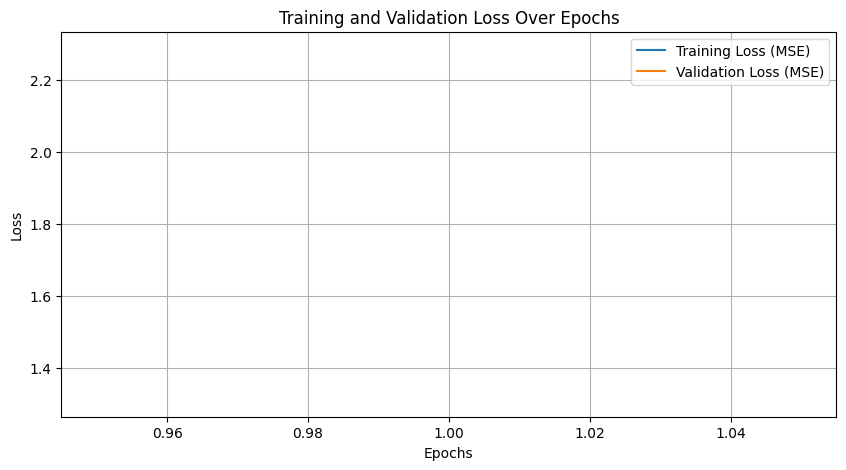

In [ ]:
# --- Training Loop ---
if model and train_dl and val_dl: # Proceed only if model and dataloaders are initialized
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    print(f"\n--- Starting Training for {num_epochs} epochs ---")
    for epoch in range(num_epochs):
        model.train() # Set model to training mode
        running_loss = 0.0

        for i, (frames, labels) in enumerate(train_dl): # frames, labels already on device
            optimizer.zero_grad()

            outputs = model(frames) # Forward pass
            loss = criterion(outputs, labels) # Calculate loss

            loss.backward() # Backward pass
            optimizer.step() # Update weights

            running_loss += loss.item() * frames.size(0) # Accumulate loss (multiply by batch size for proper averaging)

            if (i + 1) % 10 == 0: # Print progress every 10 batches
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_dl.dl)}], Train Loss: {loss.item():.4f}")

        epoch_train_loss = running_loss / len(train_dl.dl.dataset) # Average loss over all training samples
        train_losses.append(epoch_train_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Train Loss: {epoch_train_loss:.4f}")

        # Validation phase
        model.eval() # Set model to evaluation mode
        val_running_loss = 0.0
        with torch.no_grad(): # Disable gradient calculations
            for frames, labels in val_dl:
                outputs = model(frames)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * frames.size(0)

        epoch_val_loss = val_running_loss / len(val_dl.dl.dataset) # Average loss over all validation samples
        val_losses.append(epoch_val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {epoch_val_loss:.4f}")

        # Save the best model based on validation loss
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'best_video_transformer_osats_model.pth')
            print(f"Epoch {epoch+1}: New best model saved with Val Loss: {best_val_loss:.4f}")

    print("--- Finished Training ---")

    # Plotting training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss (MSE)')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss (MSE)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Skipping training loop as model or dataloaders are not initialized.")



Loading best model for evaluation...

--- Evaluating on Test Set ---
Average Test Loss (MSE): 1.4148

Mean Absolute Error (MAE) on Test Set:
  OSATS_RESPECT: 0.8116
  OSATS_MOTION: 0.8340
  OSATS_INSTRUMENT: 0.8786
  OSATS_SUTURE: 1.0523
  OSATS_FLOW: 0.9474
  OSATS_KNOWLEDGE: 1.1803
  OSATS_PERFORMANCE: 0.9204
  OSATS_FINAL_QUALITY: 1.2992
  Overall MAE (average across skills): 0.9905
  Overall MAE (direct): 0.9905


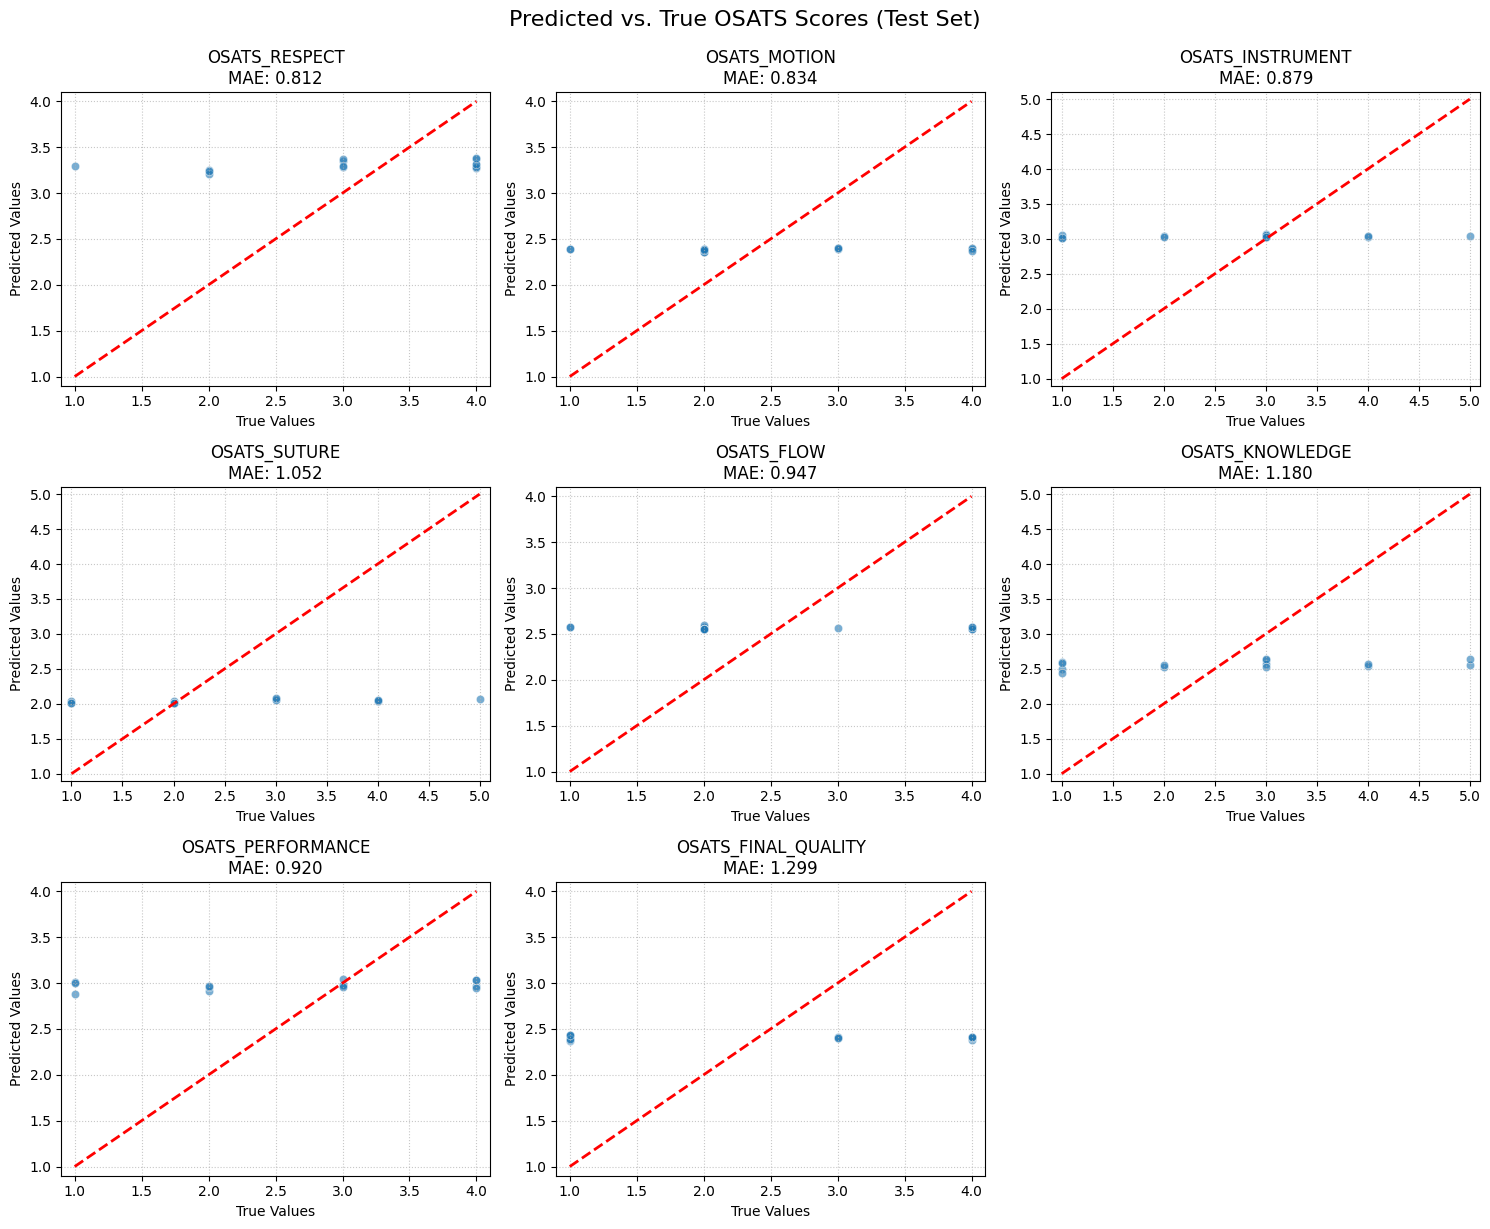

In [ ]:
# --- Evaluation on Test Set ---
if model and test_dl: # Proceed only if model and test_dl are initialized
    # Load the best model saved during training
    if os.path.exists('best_video_transformer_osats_model.pth'):
        print("\nLoading best model for evaluation...")
        model.load_state_dict(torch.load('best_video_transformer_osats_model.pth', map_location=device))
    else:
        print("\nWarning: No 'best_video_transformer_osats_model.pth' found. Evaluating with the last state of the model.")

    model.eval() # Set model to evaluation mode
    test_predictions_list = []
    test_true_labels_list = []
    test_running_loss = 0.0

    print("\n--- Evaluating on Test Set ---")
    with torch.no_grad():
        for frames, labels in test_dl:
            outputs = model(frames)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item() * frames.size(0)

            test_predictions_list.extend(outputs.cpu().numpy())
            test_true_labels_list.extend(labels.cpu().numpy())

    if len(test_dl.dl.dataset) > 0:
      average_test_loss = test_running_loss / len(test_dl.dl.dataset)
      print(f"Average Test Loss (MSE): {average_test_loss:.4f}")

      test_predictions_np = np.array(test_predictions_list)
      test_true_labels_np = np.array(test_true_labels_list)

      # Calculate Mean Absolute Error (MAE) for each OSATS skill
      mae_per_skill = np.mean(np.abs(test_predictions_np - test_true_labels_np), axis=0)
      overall_mae = np.mean(mae_per_skill) # MAE of MAEs, or simply np.mean(np.abs(preds - trues))

      print("\nMean Absolute Error (MAE) on Test Set:")
      for i, skill_name in enumerate(OSATS_COLUMNS_INDIVIDUAL):
          print(f"  {skill_name}: {mae_per_skill[i]:.4f}")
      print(f"  Overall MAE (average across skills): {overall_mae:.4f}")
      print(f"  Overall MAE (direct): {np.mean(np.abs(test_predictions_np - test_true_labels_np)):.4f}")


      # Scatter plots of predicted vs true for each skill
      num_skills = test_predictions_np.shape[1]
      # Determine subplot layout (e.g., 2 rows or 3 rows)
      n_cols = 3
      n_rows = (num_skills + n_cols - 1) // n_cols # Calculate rows needed

      fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
      axes = axes.flatten() # Flatten to 1D array for easy iteration

      for i in range(num_skills):
          min_val = min(test_true_labels_np[:, i].min(), test_predictions_np[:, i].min())
          max_val = max(test_true_labels_np[:, i].max(), test_predictions_np[:, i].max())

          axes[i].scatter(test_true_labels_np[:, i], test_predictions_np[:, i], alpha=0.6, edgecolors='w', linewidth=0.5)
          axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2) # Diagonal line for perfect prediction
          axes[i].set_xlabel("True Values")
          axes[i].set_ylabel("Predicted Values")
          axes[i].set_title(f"{OSATS_COLUMNS_INDIVIDUAL[i]}\nMAE: {mae_per_skill[i]:.3f}")
          axes[i].grid(True, linestyle=':', alpha=0.7)
          axes[i].set_xlim(min_val - 0.1, max_val + 0.1) # Add a bit of padding
          axes[i].set_ylim(min_val - 0.1, max_val + 0.1)


      # Hide any unused subplots
      for j in range(num_skills, len(axes)):
          fig.delaxes(axes[j])

      plt.tight_layout()
      plt.suptitle("Predicted vs. True OSATS Scores (Test Set)", fontsize=16, y=1.02) # Add overall title
      plt.show()
    else:
        print("Test dataset is empty. Skipping evaluation metrics.")
else:
    print("Skipping evaluation as model or test dataloader is not initialized.")



Loading best model for evaluation...

--- Evaluating on Test Set ---
Average Test Loss (MSE or other criterion): 1.4148

Mean Absolute Error (MAE) on Test Set:
  OSATS_RESPECT: 0.8116
  OSATS_MOTION: 0.8340
  OSATS_INSTRUMENT: 0.8786
  OSATS_SUTURE: 1.0523
  OSATS_FLOW: 0.9474
  OSATS_KNOWLEDGE: 1.1803
  OSATS_PERFORMANCE: 0.9204
  OSATS_FINAL_QUALITY: 1.2992
  Overall MAE (average across skills): 0.9905
  Overall MAE (direct): 0.9905

F1-Score (treating rounded scores as classes) on Test Set:
  OSATS_RESPECT: 0.1270
  OSATS_MOTION: 0.2571
  OSATS_INSTRUMENT: 0.2571
  OSATS_SUTURE: 0.1270
  OSATS_FLOW: 0.0095
  OSATS_KNOWLEDGE: 0.1429
  OSATS_PERFORMANCE: 0.1270
  OSATS_FINAL_QUALITY: 0.0000
  Overall F1-Score (average across skills, weighted): 0.1310


ValueError: Invalid format specifier '.3f if i < len(f1_scores_per_skill) else 'N/A'' for object of type 'float'

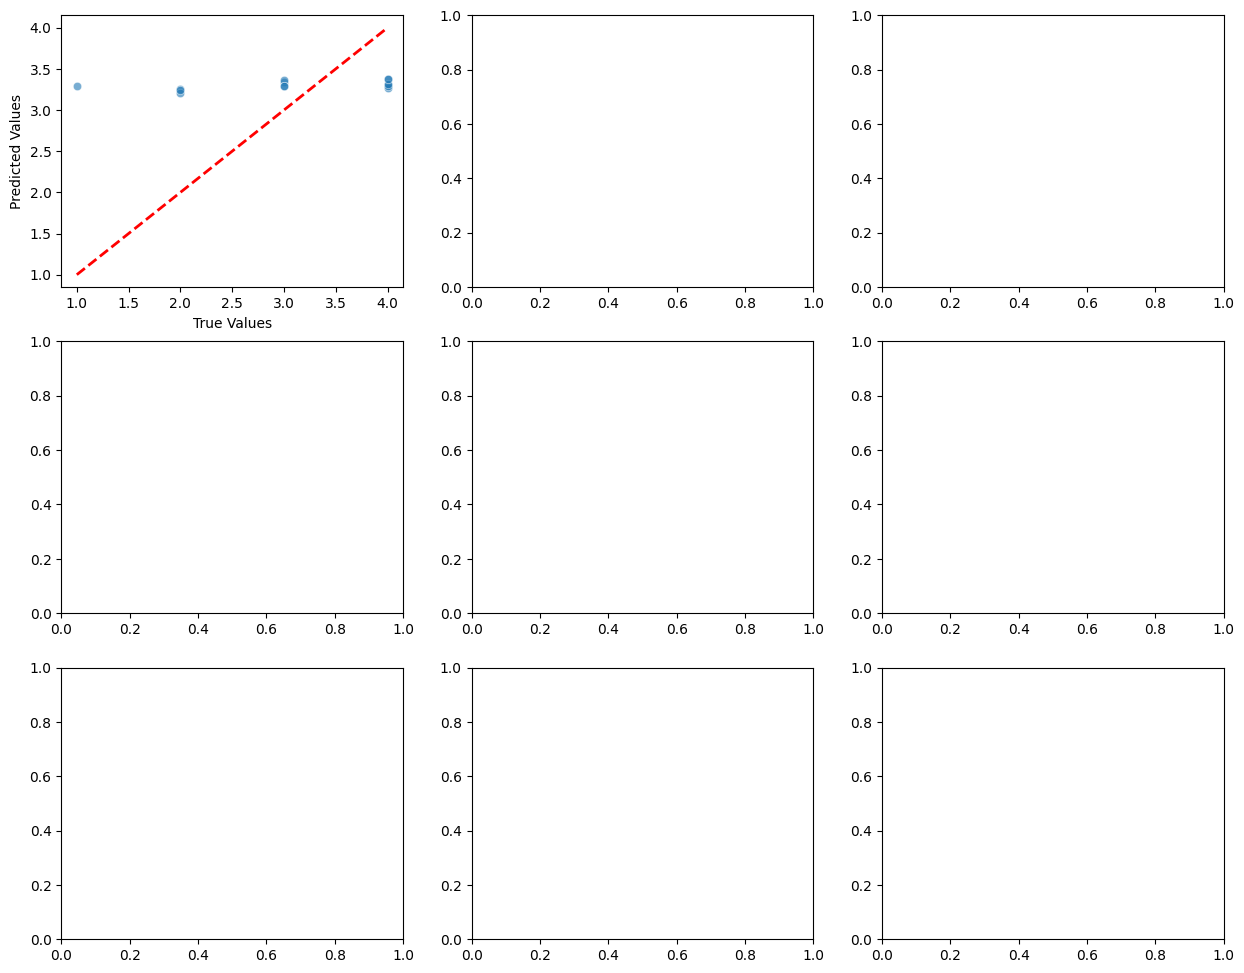

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score # <<< ADICIONADO

# Supondo que as seguintes variáveis já estão definidas no seu ambiente:
# model, test_dl, device, criterion, OSATS_COLUMNS_INDIVIDUAL

# --- Evaluation on Test Set ---
if model and test_dl: # Proceed only if model and test_dl are initialized
    # Load the best model saved during training
    if os.path.exists('best_video_transformer_osats_model.pth'):
        print("\nLoading best model for evaluation...")
        model.load_state_dict(torch.load('best_video_transformer_osats_model.pth', map_location=device))
    else:
        print("\nWarning: No 'best_video_transformer_osats_model.pth' found. Evaluating with the last state of the model.")

    model.eval() # Set model to evaluation mode
    test_predictions_list = []
    test_true_labels_list = []
    test_running_loss = 0.0

    print("\n--- Evaluating on Test Set ---")
    with torch.no_grad():
        for frames, labels in test_dl:
            frames = frames.to(device) # Ensure frames are on the correct device
            labels = labels.to(device) # Ensure labels are on the correct device

            outputs = model(frames)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item() * frames.size(0)

            test_predictions_list.extend(outputs.cpu().numpy())
            test_true_labels_list.extend(labels.cpu().numpy())

    if hasattr(test_dl, 'dl') and hasattr(test_dl.dl, 'dataset') and len(test_dl.dl.dataset) > 0: # Check more robustly
      average_test_loss = test_running_loss / len(test_dl.dl.dataset)
      print(f"Average Test Loss (MSE or other criterion): {average_test_loss:.4f}")

      test_predictions_np = np.array(test_predictions_list)
      test_true_labels_np = np.array(test_true_labels_list)

      # --- Calculate Mean Absolute Error (MAE) for each OSATS skill ---
      mae_per_skill = np.mean(np.abs(test_predictions_np - test_true_labels_np), axis=0)
      overall_mae = np.mean(mae_per_skill)

      print("\nMean Absolute Error (MAE) on Test Set:")
      for i, skill_name in enumerate(OSATS_COLUMNS_INDIVIDUAL):
          print(f"  {skill_name}: {mae_per_skill[i]:.4f}")
      print(f"  Overall MAE (average across skills): {overall_mae:.4f}")
      print(f"  Overall MAE (direct): {np.mean(np.abs(test_predictions_np - test_true_labels_np)):.4f}")

      # --- Calcular F1-Score (convertendo para problema de classificação) ---
      # Arredondar os valores verdadeiros e previstos para o inteiro mais próximo para tratá-los como classes
      # Se seus rótulos verdadeiros já são inteiros, você pode pular o arredondamento para test_true_labels_rounded
      # No entanto, é bom ser consistente, e as previsões do modelo provavelmente são floats.
      test_true_labels_rounded = np.round(test_true_labels_np).astype(int)
      test_predictions_rounded = np.round(test_predictions_np).astype(int)

      f1_scores_per_skill = []
      print("\nF1-Score (treating rounded scores as classes) on Test Set:")

      num_skills_for_f1 = test_true_labels_rounded.shape[1] # Should be same as num_skills for MAE

      for i in range(num_skills_for_f1):
          true_classes_skill = test_true_labels_rounded[:, i]
          pred_classes_skill = test_predictions_rounded[:, i]

          # 'average' pode ser 'micro', 'macro', 'weighted', or None (para score por classe)
          # 'weighted' é uma boa escolha para multiclasse desbalanceada.
          # 'zero_division=0' evita warnings se uma classe não tem previsões/verdadeiros, resultando em F1=0 para essa classe.
          # Se você tiver apenas 2 classes efetivas após o arredondamento (ex: proficiente/não proficiente),
          # você pode precisar ajustar 'average' e 'pos_label' se quiser um F1 binário.
          # Para multiclasse (ex: scores 1, 2, 3, 4, 5 como classes), 'weighted' ou 'macro' são comuns.
          current_f1 = f1_score(true_classes_skill, pred_classes_skill, average='weighted', zero_division=0)
          f1_scores_per_skill.append(current_f1)
          print(f"  {OSATS_COLUMNS_INDIVIDUAL[i]}: {current_f1:.4f}")

      if f1_scores_per_skill:
          overall_f1_score = np.mean(f1_scores_per_skill)
          print(f"  Overall F1-Score (average across skills, weighted): {overall_f1_score:.4f}")
      else:
          print("  Could not calculate F1-scores (possibly no skills).")

      # --- Scatter plots of predicted vs true for each skill ---
      num_skills_plot = test_predictions_np.shape[1]
      n_cols = 3
      n_rows = (num_skills_plot + n_cols - 1) // n_cols

      fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
      axes = axes.flatten()

      for i in range(num_skills_plot):
          min_val = min(test_true_labels_np[:, i].min(), test_predictions_np[:, i].min())
          max_val = max(test_true_labels_np[:, i].max(), test_predictions_np[:, i].max())

          axes[i].scatter(test_true_labels_np[:, i], test_predictions_np[:, i], alpha=0.6, edgecolors='w', linewidth=0.5)
          axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
          axes[i].set_xlabel("True Values")
          axes[i].set_ylabel("Predicted Values")
          axes[i].set_title(f"{OSATS_COLUMNS_INDIVIDUAL[i]}\nMAE: {mae_per_skill[i]:.3f}\nF1 (round): {f1_scores_per_skill[i]:.3f if i < len(f1_scores_per_skill) else 'N/A'}")
          axes[i].grid(True, linestyle=':', alpha=0.7)
          axes[i].set_xlim(min_val - 0.1, max_val + 0.1)
          axes[i].set_ylim(min_val - 0.1, max_val + 0.1)

      for j in range(num_skills_plot, len(axes)):
          fig.delaxes(axes[j])

      plt.tight_layout()
      plt.suptitle("Predicted vs. True OSATS Scores (Test Set)", fontsize=16, y=1.02)
      plt.show()
    else:
        print("Test dataset is empty or dataloader structure is not as expected. Skipping evaluation metrics.")
else:
    print("Skipping evaluation as model or test dataloader is not initialized.")